In [1]:
import struct
import numpy as np
from PIL import Image


def read_record_ETL8G(f):
    s = f.read(8199)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

def read_hira():
    hira = np.zeros([71, 160, 127, 128], dtype=np.uint8)

    for i in range (1,33):
        filename = 'ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_record_ETL8G(f)
                    if b'.HIRA' in r[2] or b'.WO.' in r[2]:
                        if not b'KAI' in r[2] and not b'HEI' in r[2]:
                            hira[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                            char += 1
    np.savez_compressed("hiragana.npz", hira)
    
read_hira()           

In [2]:
import skimage.transform
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

filename = 'hiragana.npz'
char = 71
row, col = 48,48
writ = 160

hira = np.load(filename)['arr_0'].reshape([-1,127,128]).astype(np.float32) / 15

X = np.zeros([char*writ,row,col], dtype=np.float32)

for i in range(char*writ):
    X[i] = skimage.transform.resize(hira[i], (row,col))

arr = np.arange(char)
y = np.repeat(arr,writ)

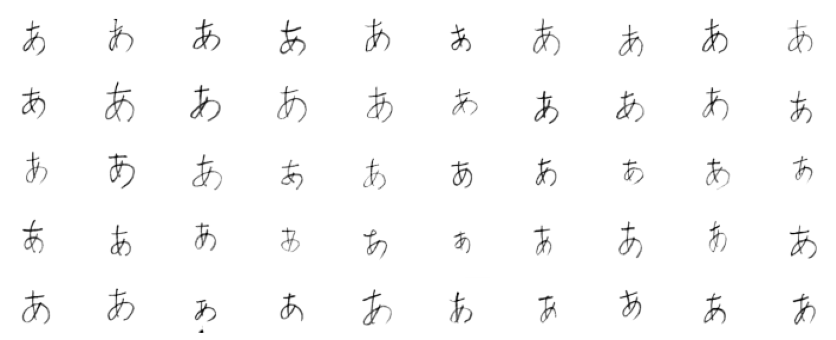

In [3]:
import matplotlib.pyplot as plt
# plot sample
fig, ax = plt.subplots(5, 10, figsize=(15,6))
for ax, img in zip(ax.ravel(), X):
    ax.axis('off')
    ax.imshow(img, cmap = plt.cm.gray_r)

In [5]:
# split training and test data
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2)

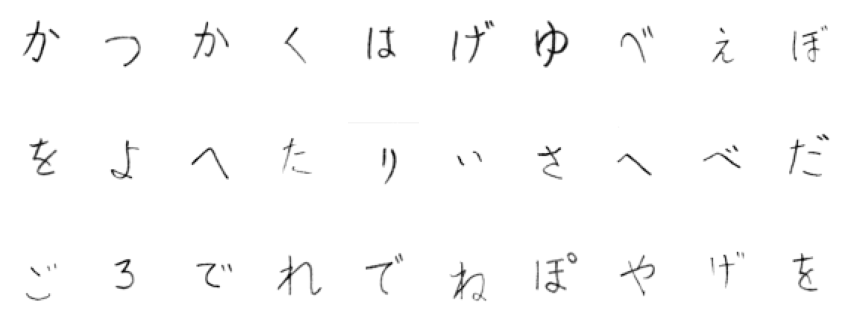

In [6]:
# plot sample
fig, ax = plt.subplots(3, 10, figsize=(15,6))
for ax, img in zip(ax.ravel(), train_X):
    ax.axis('off')
    ax.imshow(np.reshape(img, (48,48)), cmap = plt.cm.gray_r)

In [9]:
from keras import backend as K


if K.image_data_format() == 'channels_first':
    train_X = train_X.reshape(train_X.shape[0], 1, row, col)
    test_X = test_X.reshape(test_X.shape[0], 1, row, col)
    shape = (1, row, col)
else:
    train_X = train_X.reshape(train_X.shape[0], row, col, 1)
    test_X = test_X.reshape(test_X.shape[0], row, col, 1)
    shape = (row, col, 1)

In [9]:
train_y = np_utils.to_categorical(train_y, writ)
test_y = np_utils.to_categorical(test_y, writ)

In [26]:
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.20)
datagen.fit(train_X)

In [13]:
import keras
from keras import initializers
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential


model = keras.Sequential([
  keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dense(writ, activation="softmax")
])

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(datagen.flow(train_X, train_y, batch_size=16), 
                    steps_per_epoch=train_X.shape[0]//16,
                    epochs=30, 
                    validation_data=(test_X, test_y))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [ ]:
#save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("hiragana_w.h5")
model.save("hiragana.h5")
print("Models saved.")